# MMAD EDA (End-to-End Project 준비용)

이 노트북은 **MMAD 데이터셋 구조 + 질문/옵션 분포 + 템플릿(shot) 구성 + 이미지/마스크 통계 + 평가 결과 분석**까지 한 번에 확인하도록 구성했습니다.

- 경로는 **고정하지 않습니다.** (Colab/AWS/로컬 어디서든 `MMAD_ROOT`만 바꾸면 실행)
- `mmad.json`만 있으면 동작합니다.
- `metadata.csv`, `domain_knowledge.json`이 있으면 추가 분석을 합니다.

> 실행 팁: 첫 셀에서 `MMAD_ROOT`를 정확히 지정한 뒤, 위에서 아래로 실행하세요.


In [1]:
from __future__ import annotations

import os
import json
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd

# 이미지/마스크 통계용 (없으면 설치 필요)
from PIL import Image


## 0) 경로 설정

아래 `MMAD_ROOT`는 `mmad.json`이 들어있는 폴더(=MMAD 루트)를 가리켜야 합니다.

예)
- 로컬: `/Volumes/T7/Dataset/MMAD`
- 압축을 풀었다면: `.../dataset/MMAD`
- Colab: `/content/MMAD`


In [3]:
# ======= TODO: 여기를 본인 환경에 맞게 수정 =======
MMAD_ROOT = Path(os.environ.get("MMAD_ROOT", "/Volumes/T7/Dataset/MMAD")).expanduser()
# ===============================================

MMAD_JSON = MMAD_ROOT / "mmad.json"
META_CSV  = MMAD_ROOT / "metadata.csv"          # 없으면 자동 스킵
DK_JSON   = MMAD_ROOT / "domain_knowledge.json" # 없으면 자동 스킵

print("MMAD_ROOT:", MMAD_ROOT)
print("mmad.json exists:", MMAD_JSON.exists(), MMAD_JSON)


MMAD_ROOT: /Volumes/T7/Dataset/MMAD
mmad.json exists: True /Volumes/T7/Dataset/MMAD/mmad.json


### (선택) MMAD 루트를 자동 탐색하고 싶으면
`MMAD_ROOT`가 애매할 때 아래 함수를 쓰면, 지정한 폴더 아래에서 `mmad.json`을 찾아줍니다.


In [4]:
def find_mmad_root(start: str | Path) -> Path:
    start = Path(start).expanduser()
    for p in [start] + list(start.rglob("mmad.json")):
        if p.name == "mmad.json":
            return p.parent
    raise FileNotFoundError(f"mmad.json not found under: {start}")

# 예:
# MMAD_ROOT = find_mmad_root('/content')


## 1) mmad.json 로드 & 기본 구조 확인

In [5]:
with MMAD_JSON.open("r", encoding="utf-8") as f:
    mmad = json.load(f)

print("num images:", len(mmad))
first_key = next(iter(mmad.keys()))
print("first key:", first_key)
print("fields:", mmad[first_key].keys())
print("conversation example:", mmad[first_key]["conversation"][0])


num images: 8366
first key: DS-MVTec/bottle/image/broken_large/000.png
fields: dict_keys(['image_path', 'conversation', 'mask_path', 'similar_templates', 'random_templates'])
conversation example: {'Question': 'Is there any defect in the object?', 'Answer': 'A', 'Options': {'A': 'Yes.', 'B': 'No.'}, 'type': 'Anomaly Detection', 'annotation': True}


## 2) 핵심 파싱 로직

- `query_image`: 이미지 상대경로 (mmad.json의 key 또는 `image_path`)
- `mask_path`: (있으면) 마스크 상대경로
- `random_templates`, `similar_templates`
- `conversation`: 질문 리스트
  - `Question`, `Answer`, `Options`, `type` 형태


In [6]:
def parse_source_and_category(rel_path: str) -> tuple[str, str]:
    # 예: DS-MVTec/bottle/image/...  -> source=DS-MVTec, category=bottle
    parts = rel_path.split("/")
    source = parts[0] if len(parts) > 0 else "unknown"
    category = parts[1] if len(parts) > 1 else "unknown"
    return source, category

def normalize_options(opts) -> dict:
    # opts가 dict(A->text)거나 list 등일 수 있음. dict 형태로 정규화.
    if isinstance(opts, dict):
        return {str(k).strip(): str(v).strip() for k,v in opts.items()}
    if isinstance(opts, list):
        out = {}
        for i, v in enumerate(opts):
            out[chr(ord("A")+i)] = str(v).strip()
        return out
    return {"A": str(opts)}

rows = []
for k, meta in mmad.items():
    rel_img = meta.get("image_path") or k
    src, cat = parse_source_and_category(rel_img)
    mask = meta.get("mask_path")
    sim_t = meta.get("similar_templates", []) or []
    rnd_t = meta.get("random_templates", []) or []

    for q in meta.get("conversation", []):
        question = q.get("Question") or q.get("question") or ""
        answer   = q.get("Answer") or q.get("answer") or ""
        qtype    = q.get("type") or q.get("question_type") or "unknown"
        opts     = normalize_options(q.get("Options") or q.get("options") or {})
        rows.append({
            "query_image": rel_img,
            "source": src,
            "category": cat,
            "mask_path": mask,
            "num_similar_templates": len(sim_t),
            "num_random_templates": len(rnd_t),
            "question_type": qtype,
            "question": question,
            "answer": str(answer).strip(),
            "num_options": len(opts),
            "options_keys": "".join(sorted(opts.keys())),
        })

df = pd.DataFrame(rows)
df.head(), df.shape


(                  query_image source      category  \
 0  image/broken_large/000.png  image  broken_large   
 1  image/broken_large/000.png  image  broken_large   
 2  image/broken_large/000.png  image  broken_large   
 3  image/broken_large/000.png  image  broken_large   
 4  image/broken_large/000.png  image  broken_large   
 
                                 mask_path  num_similar_templates  \
 0  rbg_mask/broken_large/000_rbg_mask.png                      8   
 1  rbg_mask/broken_large/000_rbg_mask.png                      8   
 2  rbg_mask/broken_large/000_rbg_mask.png                      8   
 3  rbg_mask/broken_large/000_rbg_mask.png                      8   
 4  rbg_mask/broken_large/000_rbg_mask.png                      8   
 
    num_random_templates          question_type  \
 0                     8      Anomaly Detection   
 1                     8  Defect Classification   
 2                     8    Defect Localization   
 3                     8     Defect Description 

## 3) 질문/타입 분포 (논문 결과 해석에 핵심)

In [7]:
# 질문 타입 분포
type_counts = df["question_type"].value_counts()
type_counts.head(20)


question_type
Anomaly Detection        8297
Defect Localization      4878
Defect Analysis          4782
Defect Description       4710
Defect Classification    4688
Object Classification    3155
Object Analysis          3084
Object Structure         3052
Object Details           3024
Name: count, dtype: int64

In [8]:
# 소스(DS-MVTec/MVTec-AD/VisA/...)별 질문 수
df["source"].value_counts()


source
test        31334
image        8235
MVTec-AD      101
Name: count, dtype: int64

In [9]:
# 카테고리별 질문 수 Top
df["category"].value_counts().head(20)


category
good                    15464
bad                      5938
logical_anomalies        2765
surface_damage           2293
opened                   2137
structural_anomalies     2119
deformation              1005
surface_anomaly           667
broken                    488
color                     465
scratch                   454
crack                     419
cap_half_open             321
cap_open                  279
combined                  267
cut                       264
hole                      224
faulty_imprint            205
contamination             197
poke                      194
Name: count, dtype: int64

### 옵션 개수 분포 (MCQ 난이도 힌트)

In [10]:
df["num_options"].value_counts().sort_index()


num_options
2     8272
4    31398
Name: count, dtype: int64

## 4) 정상 템플릿(shot) 구성 분석

In [11]:
# 이미지 기준으로 템플릿 개수 통계
img_level = df.groupby("query_image", as_index=False).agg(
    source=("source","first"),
    category=("category","first"),
    mask_path=("mask_path","first"),
    num_similar_templates=("num_similar_templates","max"),
    num_random_templates=("num_random_templates","max"),
    num_questions=("question","count"),
)

img_level.describe(include="all")


,query_image,source,category,mask_path,num_similar_templates,num_random_templates,num_questions
count,4225,4225,4225,2763,4225.0,4225.0,4225.000000
unique,4225,3,58,2763,NaN,NaN,NaN
top,MVTec-AD/pill/test/good/000.png,test,good,rbg_mask/bent/000_rbg_mask.png,NaN,NaN,NaN
freq,1,3328,1441,1,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,8.0,8.0,9.389349
std,NaN,NaN,NaN,NaN,0.0,0.0,11.288639
min,NaN,NaN,NaN,NaN,8.0,8.0,2.000000
25%,NaN,NaN,NaN,NaN,8.0,8.0,4.000000
50%,NaN,NaN,NaN,NaN,8.0,8.0,5.000000
75%,NaN,NaN,NaN,NaN,8.0,8.0,9.000000


In [12]:
img_level[["num_similar_templates","num_random_templates"]].value_counts().head(20)


num_similar_templates  num_random_templates
8                      8                       4225
Name: count, dtype: int64

## 5) 이미지/마스크 파일 존재 여부, 해상도 통계

> 경로가 큰 경우 시간이 걸릴 수 있습니다. `SAMPLE_N`으로 샘플링해서 먼저 확인하세요.


In [13]:
import random
random.seed(42)

SAMPLE_N = 300  # None이면 전체(8366) 검사
images = img_level["query_image"].tolist()
if SAMPLE_N is not None and SAMPLE_N < len(images):
    images = random.sample(images, SAMPLE_N)

def safe_size(path: Path):
    try:
        with Image.open(path) as im:
            return im.size  # (W,H)
    except Exception:
        return None

stats = []
for rel in images:
    p = MMAD_ROOT / rel
    src, cat = parse_source_and_category(rel)
    exists = p.exists()
    size = safe_size(p) if exists else None
    stats.append({
        "query_image": rel,
        "source": src,
        "category": cat,
        "exists": exists,
        "width": size[0] if size else None,
        "height": size[1] if size else None,
    })

img_stats = pd.DataFrame(stats)
img_stats["exists"].value_counts(), img_stats.dropna().describe()


(exists
 False    298
 True       2
 Name: count, dtype: int64,
        width  height
 count    2.0     2.0
 mean   800.0   800.0
 std      0.0     0.0
 min    800.0   800.0
 25%    800.0   800.0
 50%    800.0   800.0
 75%    800.0   800.0
 max    800.0   800.0)

In [14]:
# 해상도 상위 빈도
img_stats.dropna(subset=["width","height"]).assign(
    res=lambda x: x["width"].astype(int).astype(str) + "x" + x["height"].astype(int).astype(str)
)["res"].value_counts().head(20)


res
800x800    2
Name: count, dtype: int64

### 마스크 존재 여부(샘플)

In [15]:
masks = img_level[["query_image","mask_path"]].drop_duplicates()
if SAMPLE_N is not None and SAMPLE_N < len(masks):
    masks = masks.sample(SAMPLE_N, random_state=42)

def mask_exists(mask_rel: str | None):
    if not mask_rel or str(mask_rel).lower() in ("none","nan"):
        return False
    return (MMAD_ROOT / mask_rel).exists()

masks["mask_exists"] = masks["mask_path"].apply(mask_exists)
masks["mask_exists"].value_counts()


mask_exists
False    300
Name: count, dtype: int64

## 6) (옵션) metadata.csv 기반 추가 분석

In [16]:
if META_CSV.exists():
    meta_df = pd.read_csv(META_CSV)
    print("metadata.csv loaded:", meta_df.shape)
    display(meta_df.head())
else:
    meta_df = None
    print("metadata.csv not found -> skip")


metadata.csv loaded: (39672, 6)


,query_image,question,options,answer,template_image,mask
0,DS-MVTec/bottle/image/broken_large/000.png,Is there any defect in the object?,A: Yes.\nB: No.,A,MVTec-AD/bottle/train/good/001.png,DS-MVTec/bottle/image/rbg_mask/broken_large/00...
1,DS-MVTec/bottle/image/broken_large/000.png,There is a defect in the object. What is the t...,A: Foggy appearance.\nB: Color fading.\nC: Bro...,C,MVTec-AD/bottle/train/good/001.png,DS-MVTec/bottle/image/rbg_mask/broken_large/00...
2,DS-MVTec/bottle/image/broken_large/000.png,There is a defect in the object. Where is the ...,A: Top right.\nB: Top left.\nC: Center.\nD: Bo...,D,MVTec-AD/bottle/train/good/001.png,DS-MVTec/bottle/image/rbg_mask/broken_large/00...
3,DS-MVTec/bottle/image/broken_large/000.png,There is a defect in the object. What is the a...,A: A jagged irregular break.\nB: A smooth crac...,A,MVTec-AD/bottle/train/good/001.png,DS-MVTec/bottle/image/rbg_mask/broken_large/00...
4,DS-MVTec/bottle/image/broken_large/000.png,There is a defect in the object. What is the e...,A: It enhances the bottle's aesthetics.\nB: It...,B,MVTec-AD/bottle/train/good/001.png,DS-MVTec/bottle/image/rbg_mask/broken_large/00...


In [17]:
if meta_df is not None:
    # metadata.csv는 질문 단위로 flatten 되어 있어서 바로 분포 분석 가능
    # options 문자열에서 옵션 개수 추정
    def count_opts(opt_text: str) -> int:
        if not isinstance(opt_text, str):
            return 0
        # "A: ...\nB: ..." 형태
        return sum(1 for c in ["A:","B:","C:","D:","E:","F:"] if c in opt_text)

    meta_df["num_options_guess"] = meta_df["options"].apply(count_opts)
    meta_df["num_options_guess"].value_counts().sort_index()


## 7) (옵션) domain_knowledge.json 확인

In [18]:
if DK_JSON.exists():
    dk = json.loads(DK_JSON.read_text(encoding="utf-8"))
    print("domain_knowledge keys:", list(dk.keys()))
    # 예시 출력
    k0 = next(iter(dk.keys()))
    print(f"sample[{k0}] subkeys:", list(dk[k0].keys())[:10])
else:
    dk = None
    print("domain_knowledge.json not found -> skip")


domain_knowledge keys: ['MVTec', 'MVTec-LOCO', 'VisA', 'GoodsAD']
sample[MVTec] subkeys: ['zipper', 'cable', 'toothbrush', 'grid', 'transistor', 'pill', 'metal_nut', 'tile', 'capsule', 'hazelnut']


## 8) 샘플 시각화 (query + mask + template)

아래는 1~2개 샘플을 뽑아서:
- query image
- mask (있으면)
- template image (random or similar 1장)
를 확인합니다.


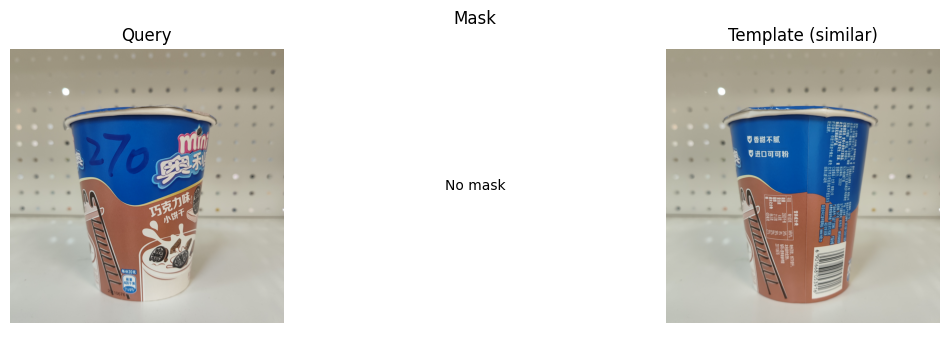

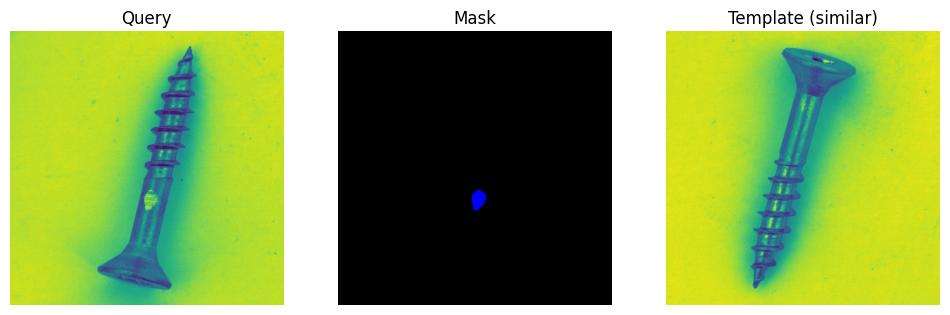

In [56]:
import matplotlib.pyplot as plt


def show_sample(rel_img: str, template_kind: str = "similar"):
    meta = mmad.get(rel_img) or mmad.get(rel_img.replace(str(MMAD_ROOT)+"/",""))
    if meta is None:
        print("meta not found for:", rel_img)
        return
    #query = MMAD_ROOT / (meta.get("image_path") or rel_img)
    query = MMAD_ROOT / rel_img
    
    if meta.get("mask_path") is not None:
        mask  = MMAD_ROOT / Path('/'.join(rel_img.split('/')[:2])) / meta.get("mask_path")
    else:
        mask = None
    tmpl_list = meta.get("similar_templates") if template_kind=="similar" else meta.get("random_templates")
    tmpl = (MMAD_ROOT / tmpl_list[0]) if tmpl_list else None

    fig, axes = plt.subplots(1, 3, figsize=(12,4))
    axes[0].set_title("Query")
    axes[0].imshow(Image.open(query))
    axes[0].axis("off")

    axes[1].set_title("Mask")
    if mask and (MMAD_ROOT / mask).exists():
        axes[1].imshow(Image.open(MMAD_ROOT / mask))
    else:
        axes[1].text(0.5,0.5,"No mask",ha="center",va="center")
    axes[1].axis("off")

    axes[2].set_title(f"Template ({template_kind})")
    if tmpl and tmpl.exists():
        axes[2].imshow(Image.open(tmpl))
    else:
        axes[2].text(0.5,0.5,"No template",ha="center",va="center")
    axes[2].axis("off")

    plt.show()

# 무작위 2개
import random
keys = list(mmad.keys())
for rel in random.sample(keys, 2):
    show_sample(rel, template_kind="similar")


## 9) (선택) 논문 제공 결과(all_result)와 비교하기

압축에 포함된 `all_result/*_accuracy.csv`가 있다면,
- 논문 baseline(각 MLLM의 0-shot/1-shot accuracy)
- 내가 만든 pipeline의 accuracy

를 한 표로 정리할 수 있습니다.

> 이 노트북은 로컬 폴더에 `all_result/`가 있을 때만 동작합니다.


In [57]:
ALL_RESULT_DIR = MMAD_ROOT.parent / "all_result"  # 압축 구조 기준: archive/all_result 와 dataset/MMAD 가 형제
if ALL_RESULT_DIR.exists():
    acc_files = sorted(ALL_RESULT_DIR.glob("*_accuracy.csv"))
    print("found files:", len(acc_files))
    rows = []
    for f in acc_files:
        try:
            d = pd.read_csv(f)
            # 보통 모델별/타입별 acc가 들어있을 수 있음. 파일/컬럼 구조가 다르면 아래를 조정하세요.
            rows.append({"file": f.name, "rows": len(d), "cols": list(d.columns)})
        except Exception as e:
            rows.append({"file": f.name, "error": str(e)})
    pd.DataFrame(rows).head(30)
else:
    print("all_result dir not found -> skip:", ALL_RESULT_DIR)


all_result dir not found -> skip: /Volumes/T7/Dataset/all_result


## 10) EDA 결론 템플릿(README/보고서에 붙이기)

아래 템플릿에 EDA 결과 수치를 채우면, 프로젝트 문서가 바로 '논문/현업 느낌'이 납니다.


In [58]:
summary = {
    "num_images": int(img_level.shape[0]),
    "num_questions": int(df.shape[0]),
    "sources": img_level["source"].value_counts().to_dict(),
    "top_categories": img_level["category"].value_counts().head(10).to_dict(),
    "question_type_dist": df["question_type"].value_counts().head(15).to_dict(),
    "template_counts": img_level[["num_similar_templates","num_random_templates"]].value_counts().head(10).to_dict(),
    "resolution_top": img_stats.dropna(subset=["width","height"]).assign(
        res=lambda x: x["width"].astype(int).astype(str)+"x"+x["height"].astype(int).astype(str)
    )["res"].value_counts().head(10).to_dict()
}
summary


{'num_images': 4225,
 'num_questions': 39670,
 'sources': {'test': 3328, 'image': 876, 'MVTec-AD': 21},
 'top_categories': {'good': 1441,
  'surface_damage': 522,
  'opened': 465,
  'deformation': 218,
  'surface_anomaly': 144,
  'logical_anomalies': 142,
  'bad': 100,
  'broken': 98,
  'structural_anomalies': 94,
  'cap_open': 79},
 'question_type_dist': {'Anomaly Detection': 8297,
  'Defect Localization': 4878,
  'Defect Analysis': 4782,
  'Defect Description': 4710,
  'Defect Classification': 4688,
  'Object Classification': 3155,
  'Object Analysis': 3084,
  'Object Structure': 3052,
  'Object Details': 3024},
 'template_counts': {(8, 8): 4225},
 'resolution_top': {'800x800': 2}}